In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
from PIL import Image 
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchsummary import summary
from datetime import datetime
import random
import os

In [2]:
%matplotlib inline
plt.style.use("ggplot")


class CFG:
    batch_size = 64
    num_epochs = 15
    workers = 4
    seed = 2021
    image_W = 64
    image_H = 64
    image_C = 3 ## number chanels  ngf = 64 #Size of feature maps in generator
    download = True
    dataroot = "data"
    nz = 100 #latent random input vector
    ngf = 64 #Size of feature maps in generator
    ndf = 64 #Size of feature maps in discriminator
    dlr = 0.0001
    glr = 0.0002
    lrelu_slope = 0.02
    device = 'cuda'  
    sample_dir = "./images_v4/"
    
if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)
dataset = torchvision.datasets.CIFAR10(root=CFG.dataroot, download=CFG.download,
                               transform=transforms.Compose([
                                  transforms.Resize([CFG.image_H, CFG.image_W]),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))


Files already downloaded and verified


In [3]:
torch.manual_seed(CFG.seed)
random.seed(CFG.seed)
np.random.seed(CFG.seed)

In [4]:
dataset[0][0].shape

torch.Size([3, 64, 64])

In [5]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def unnomalization(x):
    batch_size_ = x.size(0)
    x = x.view(batch_size_ , -1)
    x -= x.min(1, keepdim=True)[0]
    x /= x.max(1, keepdim=True)[0]
    x = x.view(batch_size_, CFG.image_C, CFG.image_H, CFG.image_W)
    return x

img, label = dataset[0]
img = unnomalization(img.unsqueeze(0)).squeeze(0) # The functions expects first dim to be batch_size
print("Min: ", img.min().item())
print("Max: ", img.max().item())

Min:  0.0
Max:  1.0


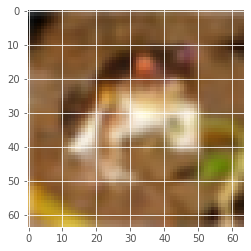

In [6]:
# show image sample with matplotlib
def plot_torch_image(img, **kwargs):
    '''
    Input image is a torch tensor with the following dims (C,H,W)
    To plot it with matplotlib, we need to change it to (H,W,C) 
    kwargs varaible is used to pass other parameters to 'imshow' function.
    '''
    plt.imshow(img.permute(1, 2, 0) , **kwargs)
    
plot_torch_image(img)

In [7]:
# Create the dataloader
data_loader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=True, drop_last=True)


## GAN 
состоит из двух глубоких сетей, генератора и дискриминатора. генератор создает изображения, прежде чем научиться его обучать. Поскольку дискриминатор представляет собой модель бинарной классификации, мы можем использовать функцию потери бинарной кросс-энтропии для количественной оценки того, насколько хорошо он может различать реальные и сгенерированные изображения.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, nc, h, w, nz, ngf):
        #ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu 
        #ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding 
        super(Generator, self).__init__()
        self.nc = nc
        self.h = h
        self.w = w
        self.ngf = ngf
        
        self.linear = nn.Linear(nz, nc * h * w)
        self.conv1 = nn.ConvTranspose2d(in_channels=nc, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(ngf)
        self.conv2 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(ngf)
        self.conv3 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(ngf)
        self.conv4 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch4 = nn.BatchNorm2d(ngf) 
        self.conv5 = nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=(3,3), stride=1, padding=1)
        # init weights
        self.linear.weight.data.normal_(0.0, 0.02) 
        self.conv1.weight.data.normal_(0.0, 0.02)
        self.conv2.weight.data.normal_(0.0, 0.02)
        self.conv3.weight.data.normal_(0.0, 0.02)
        self.conv4.weight.data.normal_(0.0, 0.02)
        self.conv5.weight.data.normal_(0.0, 0.02)
    def forward(self, x):
        bs= x.shape[0]
        x = self.linear(x)
        x = x.view(bs, self.nc, self.h, self.w)
        x = self.conv1(x)
        x = self.batch1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = nn.ReLU()(x)     
        x = self.conv3(x)
        x = self.batch3(x)
        x = nn.ReLU()(x) 
        x = self.conv4(x)
        x = self.batch4(x)
        x = nn.ReLU()(x)
        x = self.conv5(x)
        return torch.tanh(x)


class Discriminator(nn.Module):
    def __init__(self, nc, h, w, ndf):
    #conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.l_relu1 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv2 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(ndf)
        self.l_relu2 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv3 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ndf)
        self.l_relu3 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv4 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(ndf)
        self.l_relu4 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv5 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        
        self.linear = nn.Linear(262144, 1)
        # init weights
        self.conv1.weight.data.normal_(0.0, 0.02)
        self.conv2.weight.data.normal_(0.0, 0.02)
        self.conv3.weight.data.normal_(0.0, 0.02)
        self.conv4.weight.data.normal_(0.0, 0.02)
        self.conv5.weight.data.normal_(0.0, 0.02)
        self.linear.weight.data.normal_(0.0, 0.02)
    def forward(self, x):
        x = self.conv1(x)
        x = self.l_relu1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.l_relu2(x)
        x = self.conv3(x)
        x = self.bn2(x) 
        x = self.l_relu3(x)
        x = self.conv4(x)
        x = self.bn3(x) 
        x = self.l_relu4(x)
        x = self.conv5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return nn.Sigmoid()(x)


In [9]:
# create new Generator model
G = Generator(CFG.image_C, CFG.image_H, CFG.image_W, CFG.nz, CFG.ngf)
# create new Discriminator model
D = Discriminator(CFG.image_C, CFG.image_H, CFG.image_W, CFG.ndf)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


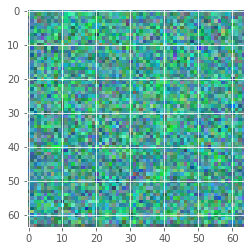

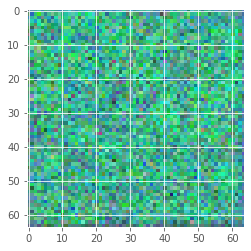

In [10]:
# show the output of model 
y = G(torch.randn(2, CFG.nz))
with torch.no_grad():
    for img in y:
        print(img.size())
        img = unnomalization(img.unsqueeze(0)).squeeze(0)
        plt.figure()
        plot_torch_image(img.detach())

In [11]:
# define the criterion is nn.BCELoss()
loss_fn = nn.BCELoss()
## Define the optimizer for generator and discrimator
G_optim = torch.optim.Adam(G.parameters(),betas=(0.5, 0.999),  lr=CFG.glr)
D_optim = torch.optim.Adam(D.parameters(),betas=(0.5, 0.999),  lr=CFG.dlr)

In [12]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optim.zero_grad()
    D_optim.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = (torch.ones(CFG.batch_size, 1) * 0.9).to(CFG.device)
    fake_labels = (torch.zeros(CFG.batch_size, 1) + 0.1).to(CFG.device)
    
    outputs = D(images)
    # Loss for real images
    loss_r = loss_fn(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz).to(CFG.device)
    fake_images = G(z)
    outputs = D(fake_images)
    loss_f = loss_fn(outputs, fake_labels)
    fake_score = outputs
    # Sum losses
    d_loss = loss_r + loss_f
    # Adjust the parameters using backprop
    d_loss.backward()
    # Compute gradients
    D_optim.step()
    # Reset gradients
    reset_grad()

    return d_loss, real_score, fake_score

In [13]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz))).to(CFG.device)
    fake_images = G(z)
    labels = (torch.ones(CFG.batch_size, 1) * 0.9).to(CFG.device)
    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = loss_fn(outputs, labels)
    # Backprop and optimize
    g_loss.backward()
    G_optim.step()
    # Reset gradients
    reset_grad()
    return g_loss, fake_images

## Start the training proccess

In [14]:
def save_fake_images(index):
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz))).to(CFG.device)
    fake_images = G(sample_vectors)
#     fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(unnomalization(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=8)

In [15]:
%%time
print(f"[{datetime.now()}] -- Training started")
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(CFG.device)
D.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
#         images = images.reshape(CFG.batch_size, -1).to(CFG.device)
        images = images.to(CFG.device)
        # Train the generator n times
        n = 3
        for _ in range(n):
            g_loss, fake_images = train_generator()
        # Train the discriminator  once
        d_loss, real_score, fake_score = train_discriminator(images)
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('[{}] -- Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(datetime.now(), epoch+1, CFG.num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

[2021-11-21 16:10:42.666991] -- Training started
[2021-11-21 16:12:09.818147] -- Epoch [1/15], Step [100/781], d_loss: 3.7556, g_loss: 3.0412, D(x): 0.12, D(G(z)): 0.05
[2021-11-21 16:13:32.559825] -- Epoch [1/15], Step [200/781], d_loss: 2.9093, g_loss: 2.9839, D(x): 0.24, D(G(z)): 0.15
[2021-11-21 16:14:53.140060] -- Epoch [1/15], Step [300/781], d_loss: 1.7352, g_loss: 1.5097, D(x): 0.51, D(G(z)): 0.41
[2021-11-21 16:16:14.217049] -- Epoch [1/15], Step [400/781], d_loss: 1.9940, g_loss: 1.8162, D(x): 0.30, D(G(z)): 0.21
[2021-11-21 16:17:34.965092] -- Epoch [1/15], Step [500/781], d_loss: 2.5088, g_loss: 0.3773, D(x): 0.73, D(G(z)): 0.86
[2021-11-21 16:18:58.437307] -- Epoch [1/15], Step [600/781], d_loss: 1.9652, g_loss: 1.0642, D(x): 0.28, D(G(z)): 0.37
[2021-11-21 16:20:25.450702] -- Epoch [1/15], Step [700/781], d_loss: 2.1924, g_loss: 0.3730, D(x): 0.76, D(G(z)): 0.83
Saving fake_images-0001.png
[2021-11-21 16:23:07.680364] -- Epoch [2/15], Step [100/781], d_loss: 1.6444, g_los

[2021-11-21 17:52:33.525300] -- Epoch [10/15], Step [400/781], d_loss: 1.4273, g_loss: 0.6098, D(x): 0.55, D(G(z)): 0.56
[2021-11-21 17:53:54.088801] -- Epoch [10/15], Step [500/781], d_loss: 1.3956, g_loss: 0.7342, D(x): 0.48, D(G(z)): 0.49
[2021-11-21 17:55:14.721842] -- Epoch [10/15], Step [600/781], d_loss: 1.3976, g_loss: 0.7329, D(x): 0.48, D(G(z)): 0.48
[2021-11-21 17:56:35.345599] -- Epoch [10/15], Step [700/781], d_loss: 1.3921, g_loss: 0.6622, D(x): 0.52, D(G(z)): 0.52
Saving fake_images-0010.png
[2021-11-21 17:59:01.277439] -- Epoch [11/15], Step [100/781], d_loss: 1.4223, g_loss: 0.6925, D(x): 0.49, D(G(z)): 0.51
[2021-11-21 18:00:21.830638] -- Epoch [11/15], Step [200/781], d_loss: 1.4165, g_loss: 0.6489, D(x): 0.52, D(G(z)): 0.54
[2021-11-21 18:01:42.394807] -- Epoch [11/15], Step [300/781], d_loss: 1.4291, g_loss: 0.6837, D(x): 0.49, D(G(z)): 0.51
[2021-11-21 18:03:03.021415] -- Epoch [11/15], Step [400/781], d_loss: 1.3950, g_loss: 0.6750, D(x): 0.51, D(G(z)): 0.51
[202

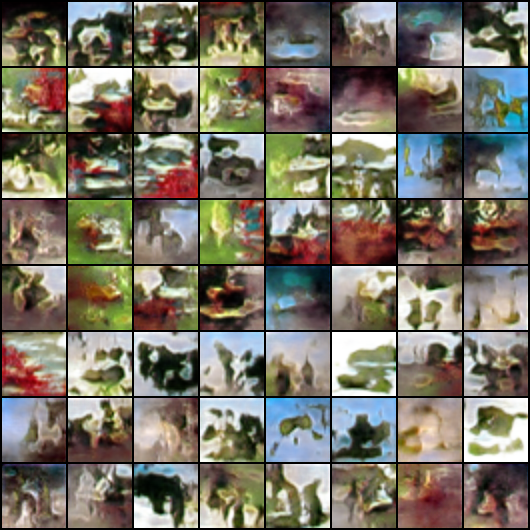

In [16]:
from IPython.display import Image
Image(os.path.join(CFG.sample_dir, 'fake_images-0015.png'))

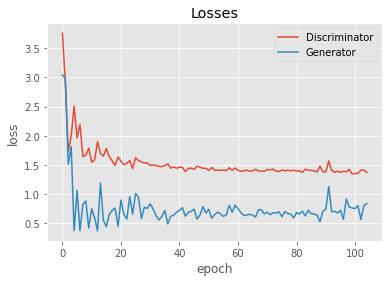

In [17]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

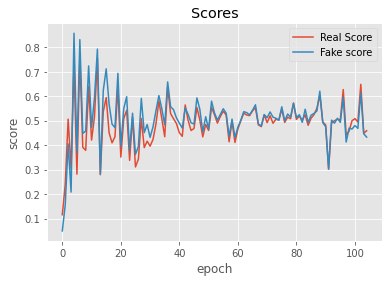

In [18]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [19]:
if not os.path.exists("./checkpoint/"):
    os.makedirs("./checkpoint/")
torch.save(
    G.state_dict(),
    "checkpoint/generator_model.pth")
torch.save(
    D.state_dict(),
    "checkpoint/discrimator_model.pth")